In [29]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("Cleaned_tweets.csv")

In [ ]:
data.head()

,Unnamed: 0,Key Word,Username,User_ID,Datetime,Favorite_count,Geo,Coordinates,Label,Text
0,1515,ass,gametheoryosmer,1.330000e+18,11-11-2020 06:55,0,NaN,NaN,1,"my lieutenant called me a ""Pussy"" for not wipi..."
1,1167,bastard,oyibutter,1.330000e+18,11-11-2020 07:25,0,NaN,NaN,0,My fwb showed me pepper. I caught bastard feel...
2,115,Bad Fuck,Bigafterglow,1.330000e+18,11-11-2020 07:09,0,NaN,NaN,0,Oh fuck! What a bad tweet.
3,1740,bitch,ItsBillcosby,1.330000e+18,11-11-2020 07:27,0,NaN,NaN,1,If the dick fit suck it bitch 〽️™️
4,983,ass,SlayerOfWaifu,1.330000e+18,11-11-2020 06:55,1,NaN,NaN,0,If you think Fairy Tail is ass you do you 🤷🏽‍♂...


In [ ]:
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics

In [ ]:
!pip3 install bert-for-tf2

     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30537 sha256=14e046314447e5c184ac3523ae08fa7331e53a1a487aa70dc06dfa9199791b41
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7303 sha256=73e5f03dddf09f8339182ee873f06aff20f5532a7fa3e974aff5f07da2c544b1
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19474 sha256=e2fcfe68a1708fbfc8a4207969c19108e88fbdcee99b0ae158e04ddd66563971
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [7]:
import tensorflow_hub as hub 
from bert import bert_tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [8]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(data.Text, data['Label'], 
                                                                          test_size=0.2, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

In [11]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [15]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    X_train, y_train, 
   
    epochs=5,
    callbacks=[checkpoint, earlystopping],
    batch_size=1,
    verbose=1
)

Epoch 1/5
2089/2089 [==============================] - 116s 56ms/step - loss: 0.0769 - accuracy: 0.9785


Epoch 2/5
2089/2089 [==============================] - 116s 56ms/step - loss: 0.0466 - accuracy: 0.9818


Epoch 3/5
2089/2089 [==============================] - 116s 56ms/step - loss: 0.0447 - accuracy: 0.9866


Epoch 4/5
2089/2089 [==============================] - 116s 55ms/step - loss: 0.0272 - accuracy: 0.9885


Epoch 5/5
2089/2089 [==============================] - 116s 55ms/step - loss: 0.0461 - accuracy: 0.9876


CPU times: user 6min 54s, sys: 2min 7s, total: 9min 2s
Wall time: 9min 40s


In [23]:
train_history.history

{'accuracy': [0.97845858335495,
  0.9818094968795776,
  0.9865964651107788,
  0.9885112643241882,
  0.9875538349151611],
 'loss': [0.07692718505859375,
  0.04659464955329895,
  0.04469507187604904,
  0.027234934270381927,
  0.04607941210269928]}

In [27]:
print(X_val[0])

[[  101  1040  2213 ...     0     0     0]
 [  101 22212  2007 ...     0     0     0]
 [  101 25391  2502 ...     0     0     0]
 ...
 [  101  2166  2038 ...     0     0     0]
 [  101  2821  2122 ...     0     0     0]
 [  101  3621 18391 ...     0     0     0]]


In [18]:
test_performance=model.evaluate(X_val,y_val)
print((test_performance))
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))



17/17 [==============================] - 4s 229ms/step - loss: 1.5301 - accuracy: 0.7897
[1.5301103591918945, 0.7896749377250671]
The loss of the model on the test set : 1.5301103591918945
The accuracy of the model on the test set : 78.96749377250671%


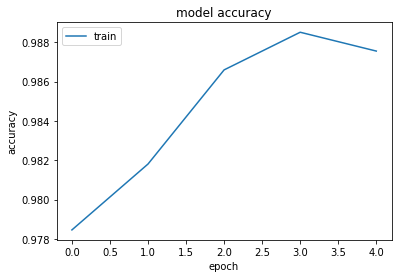

In [31]:
plt.plot(train_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

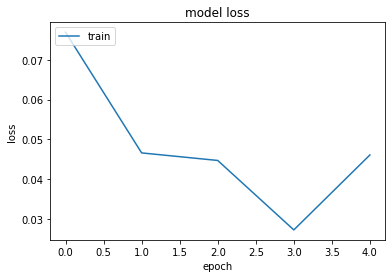

In [32]:
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
new_input = ["bite me in the ass"]

new_val = bert_encode(new_input, tokenizer, max_len=max_len)

print(model.predict(new_val))

[[0.9996673]]
